# Импорт необходимых модулей

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.utils import preprocessing
from source.code.evaluate import my_cross_validation
from source.code.visualize import plot_results
from source.code.visualize import plot_mean_results

In [3]:
import pandas as pd
import numpy as np

In [4]:
from surprise import SVD
from surprise import NMF
from surprise import SVDpp
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

# Загрузка данных

In [5]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [6]:
books = pd.read_csv('data/BX-Books.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [7]:
users = pd.read_csv('data/BX-Users.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [8]:
data_dict = {}
data_dict['books'] = books
data_dict['users'] = users
data_dict['ratings'] = ratings

# Предварительная обработка

In [9]:
preprocessed_data_dict = preprocessing(data_dict=data_dict, is_explicit=True, book_ratings_count_threshold=2, user_ratings_count_threshold=2)

Before pre-processing: Unique users count: 105283; unique items count: 340556
After pre-processing: Unique users count: 19297; unique items count: 24016


In [10]:
preprocessed_data_dict['ratings'] = preprocessed_data_dict['ratings'].rename({'User-ID': 'userID', 'ISBN': 'itemID', 'Book-Rating': 'rating'}, axis='columns')

In [11]:
reader = Reader(rating_scale=(1, 10))

In [12]:
data = Dataset.load_from_df(preprocessed_data_dict['ratings'][['userID', 'itemID', 'rating']], reader)

# Тестирование различных алгоритмов на кросс-валидации

## Метрики - RMSE, MAE

### SVD

In [13]:
algo_svd = SVD()

In [14]:
svd_cv = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5878  1.6039  1.5966  1.6015  1.6031  1.5986  0.0060  
MAE (testset)     1.2286  1.2410  1.2317  1.2374  1.2344  1.2346  0.0043  
Fit time          10.33   10.68   10.81   10.47   10.22   10.50   0.22    
Test time         0.41    0.28    0.26    0.27    0.24    0.29    0.06    


### NMF

In [15]:
algo_nmf = NMF()

In [16]:
nmf_cv = cross_validate(algo_nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6370  2.6021  2.6283  2.6420  2.6363  2.6291  0.0142  
MAE (testset)     2.2534  2.2206  2.2428  2.2610  2.2535  2.2462  0.0141  
Fit time          14.83   15.45   15.16   15.21   14.67   15.06   0.28    
Test time         0.35    0.25    0.24    0.22    0.24    0.26    0.05    


### KNN (item-based)

In [17]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [18]:
knn_item_based_cv = cross_validate(algo_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8107  1.8090  1.8029  1.8003  1.8000  1.8046  0.0045  
MAE (testset)     1.3524  1.3459  1.3479  1.3408  1.3418  1.3457  0.0042  
Fit time          31.98   31.70   32.04   34.12   32.45   32.46   0.86    
Test time         2.81    3.19    2.84    2.95    2.82    2.92    0.14    


### KNN (user-based)

In [19]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [20]:
knn_user_based_cv = cross_validate(algo_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.0056  1.9884  1.9835  1.9969  1.9930  1.9935  0.0075  
MAE (testset)     1.5550  1.5423  1.5383  1.5491  1.5467  1.5463  0.0057  
Fit time          9.88    10.38   10.25   10.30   10.02   10.17   0.19    
Test time         0.97    1.02    0.94    1.15    1.11    1.04    0.08    


## Результаты тестирования

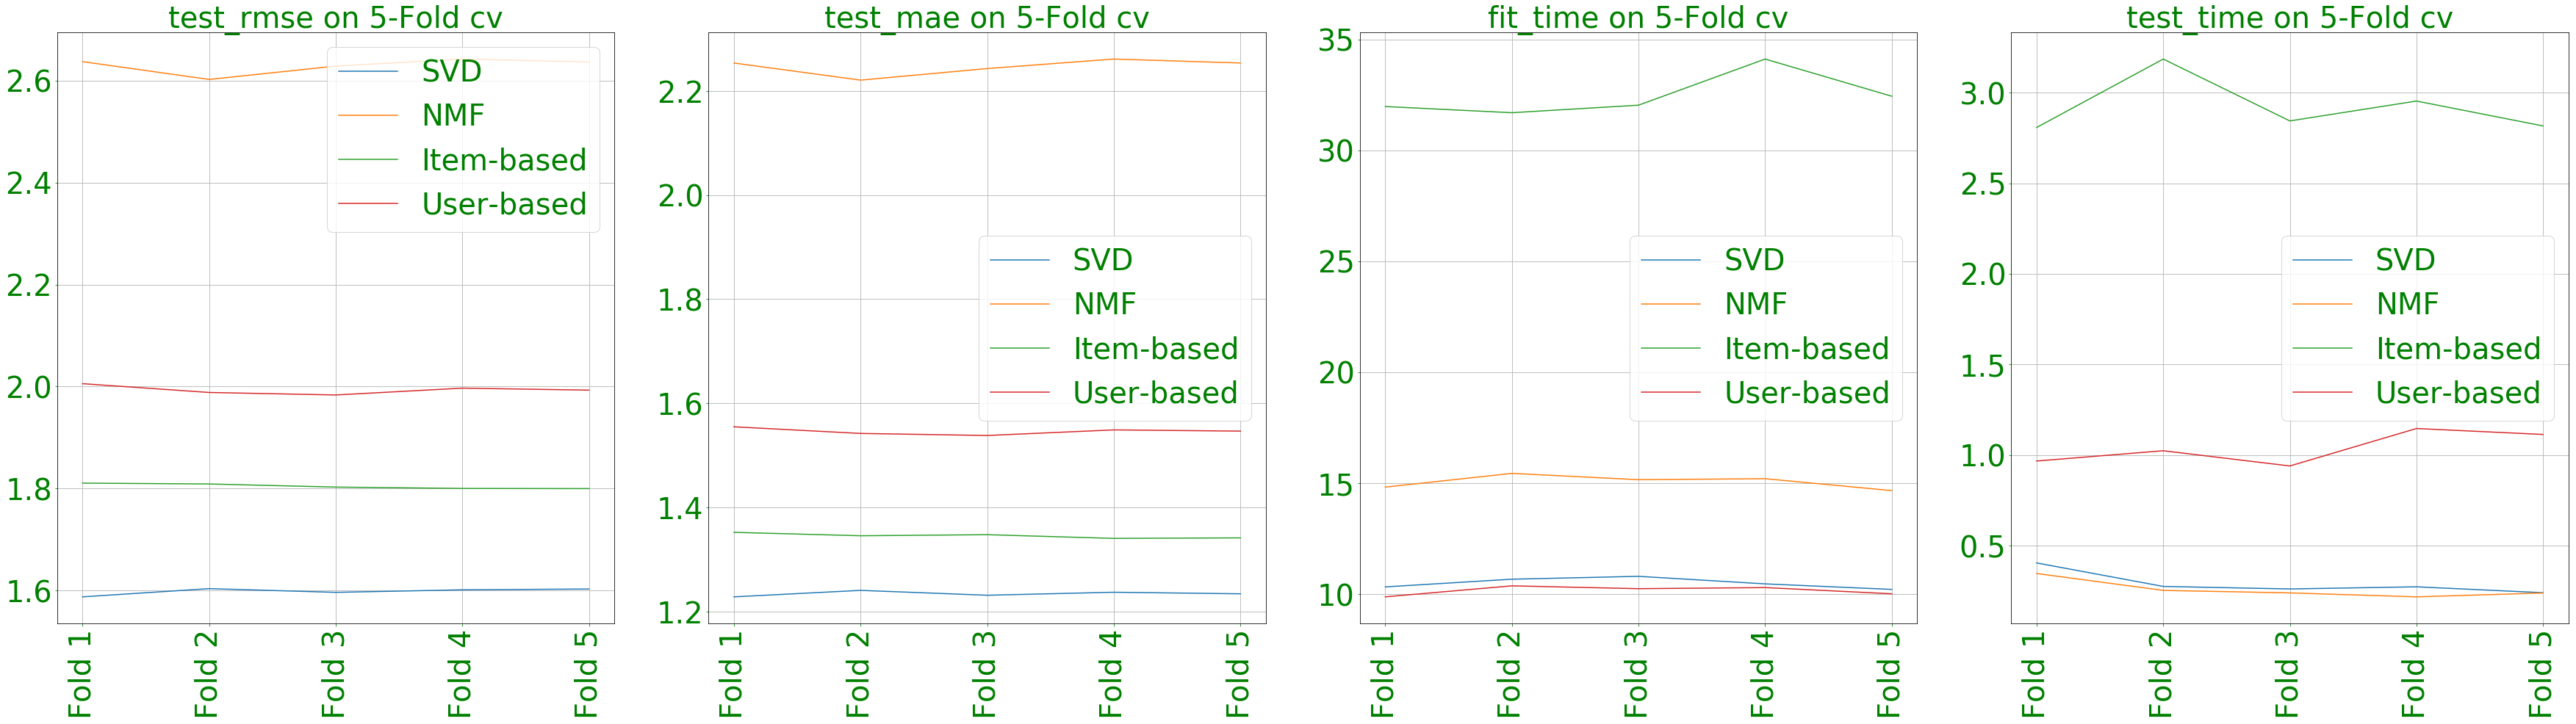

In [21]:
plot_results(
    [svd_cv, nmf_cv, knn_item_based_cv, knn_user_based_cv],
    ['SVD', 'NMF', 'Item-based', 'User-based'],
    ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
)

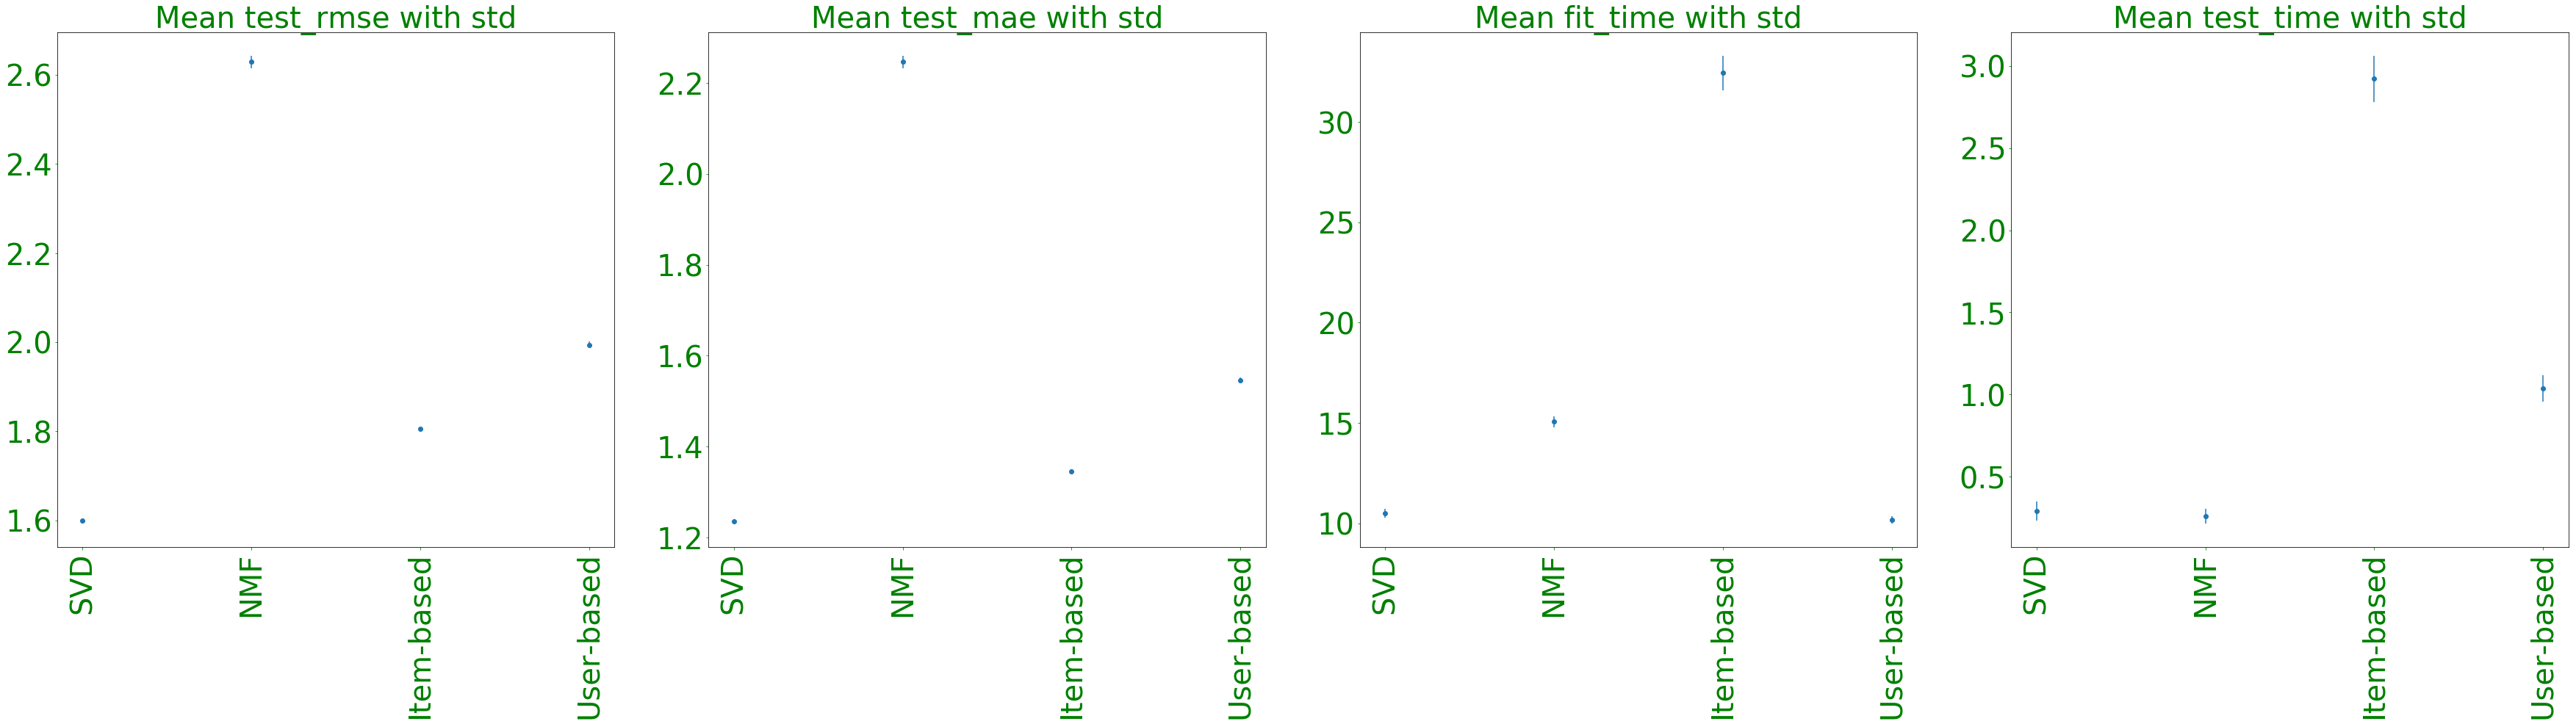

In [22]:
plot_mean_results(
    [svd_cv, nmf_cv, knn_item_based_cv, knn_user_based_cv],
    ['SVD', 'NMF', 'Item-based', 'User-based']
)

## Метрики - MAP@k, MAR@k

### SVD

In [23]:
algo_svd = SVD()

In [24]:
svd_cv = my_cross_validation(algo_svd, data, k=5, threshold=7, n_splits=5, verbose=True)

Evaluating MAP@5, MAR@5 of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAP@5 (testset)   0.7364  0.7342  0.7360  0.7397  0.7384  0.7370  0.0019  
MAR@5 (testset)   0.7360  0.7317  0.7373  0.7441  0.7409  0.7380  0.0042  
Fit time          8.16    8.14    8.31    8.09    8.17    8.17    0.07    
Test time         0.31    0.32    0.34    0.21    0.27    0.29    0.05    


### NMF

In [25]:
algo_nmf = NMF()

In [26]:
nmf_cv = my_cross_validation(algo_nmf, data, k=5, threshold=7, n_splits=5, verbose=True)

Evaluating MAP@5, MAR@5 of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAP@5 (testset)   0.2406  0.2385  0.2397  0.2434  0.2498  0.2424  0.0040  
MAR@5 (testset)   0.1524  0.1493  0.1508  0.1547  0.1596  0.1534  0.0036  
Fit time          12.45   12.07   12.13   11.89   11.88   12.08   0.21    
Test time         0.32    0.24    0.17    0.17    0.20    0.22    0.06    


### KNN (item-based)

In [27]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [28]:
knn_item_based_cv = my_cross_validation(algo_knn, data, k=5, threshold=7, n_splits=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating MAP@5, MAR@5 of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAP@5 (testset)   0.7226  0.7246  0.7201  0.7278  0.7194  0.7229  0.0031  
MAR@5 (testset)   0.7223  0.7218  0.7192  0.7273  0.7209  0.7223  0.0027  
Fit time          32.23   36.39   30.05   31.63   32.82   32.63   2.10    
Test time         3.06    2.83    3.13    3.14    2.67    2.96    0.19    


### KNN (user-based)

In [29]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [30]:
knn_user_based_cv = my_cross_validation(algo_knn, data, k=5, threshold=7, n_splits=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating MAP@5, MAR@5 of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAP@5 (testset)   0.7420  0.7337  0.7359  0.7401  0.7354  0.7374  0.0031  
MAR@5 (testset)   0.7434  0.7332  0.7392  0.7419  0.7401  0.7396  0.0035  
Fit time          10.13   10.79   10.15   10.03   10.81   10.38   0.34    
Test time         1.10    1.17    1.10    1.05    1.10    1.10    0.04    


## Результаты тестирования

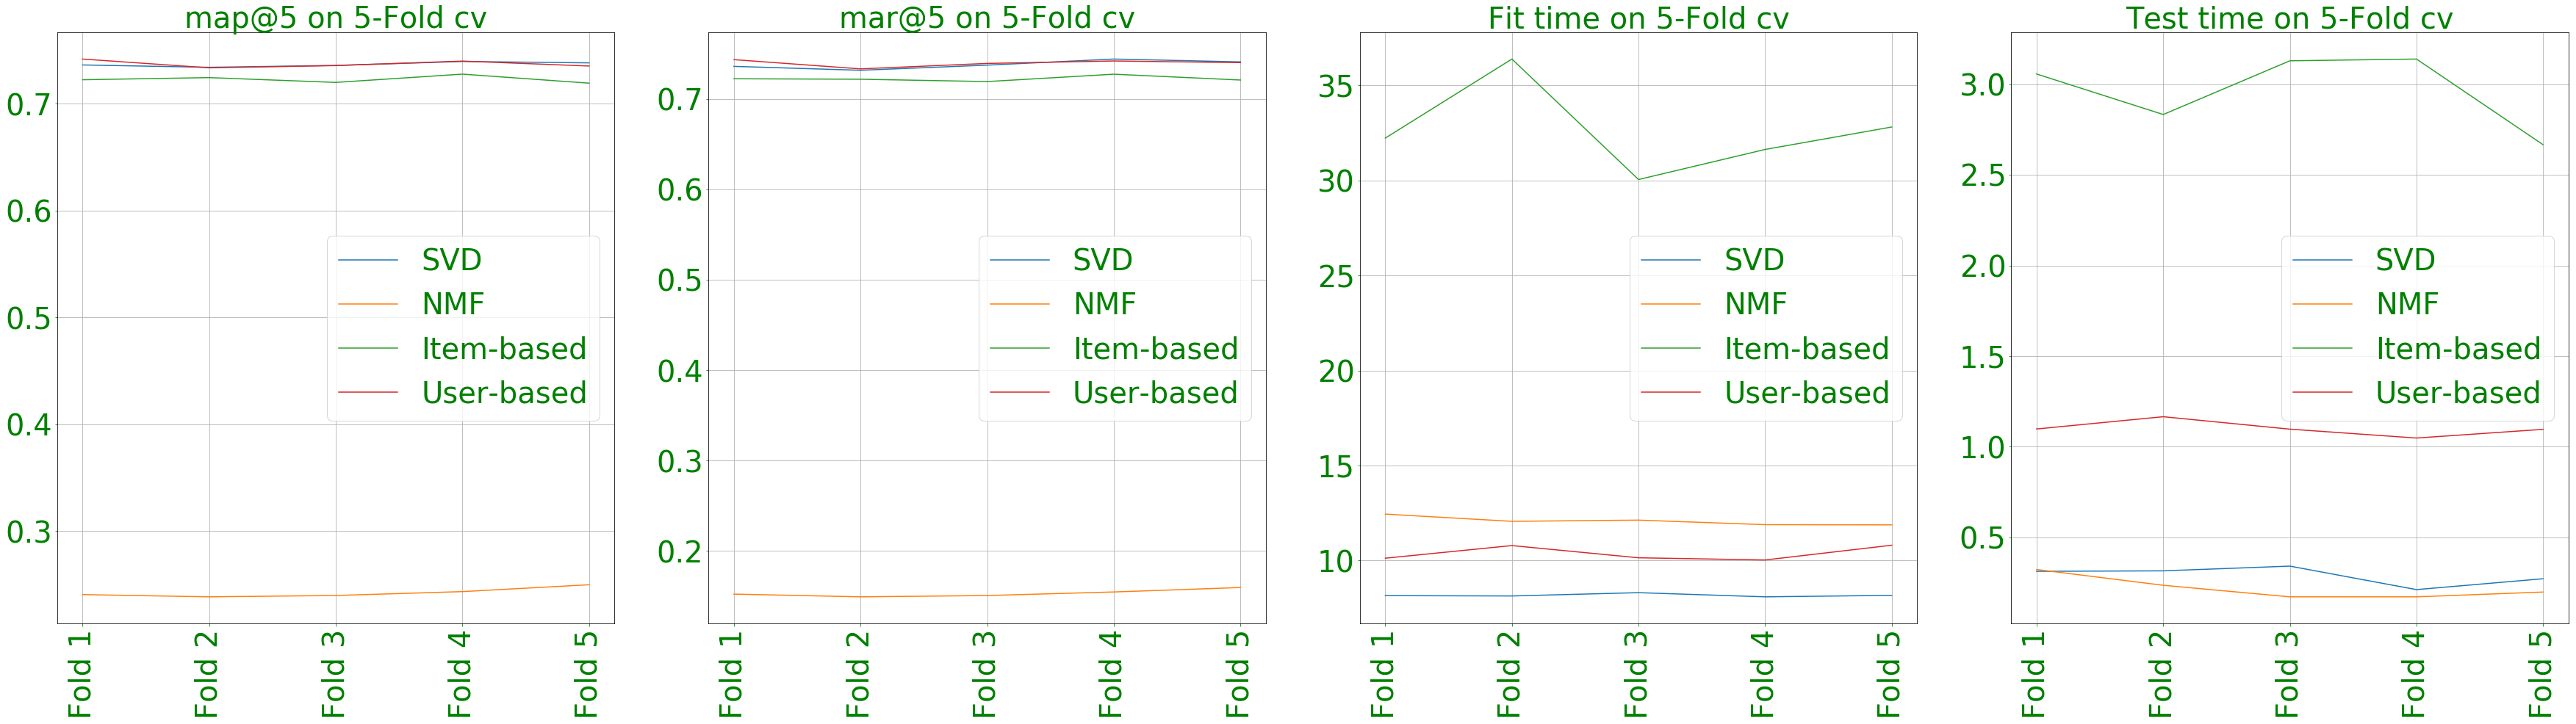

In [31]:
plot_results(
    [svd_cv, nmf_cv, knn_item_based_cv, knn_user_based_cv],
    ['SVD', 'NMF', 'Item-based', 'User-based'],
    ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
)

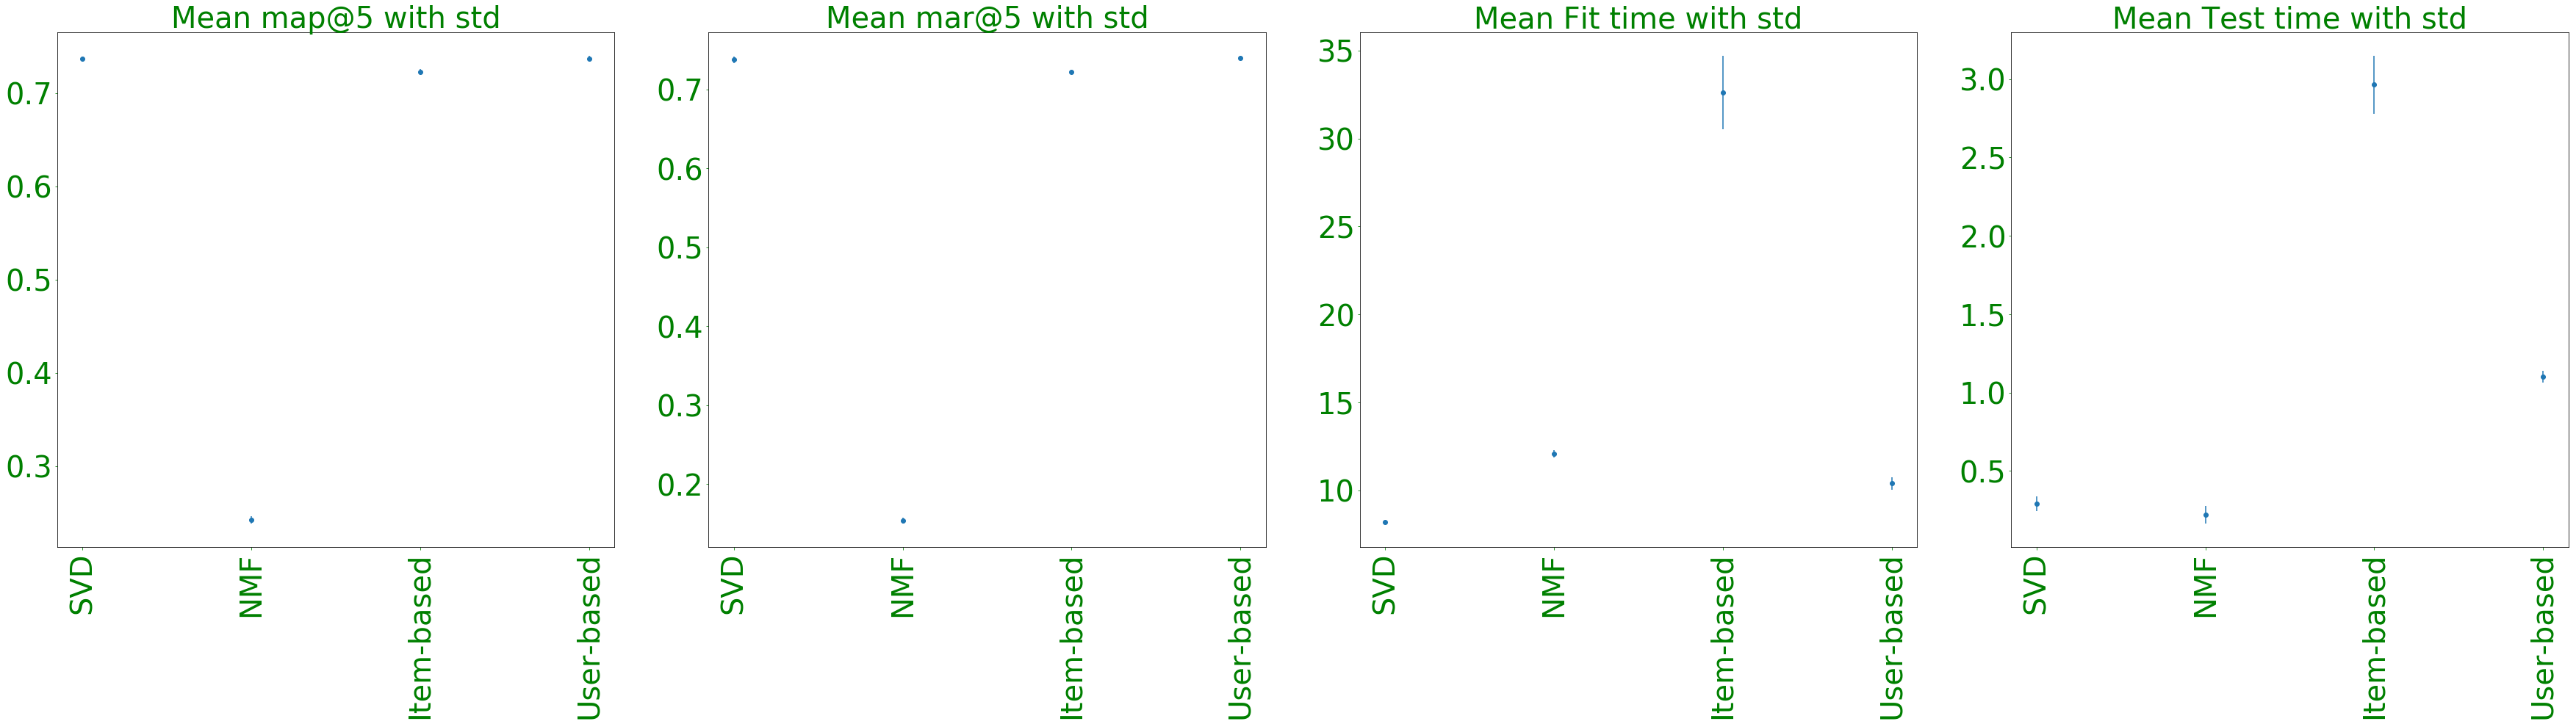

In [32]:
plot_mean_results(
    [svd_cv, nmf_cv, knn_item_based_cv, knn_user_based_cv],
    ['SVD', 'NMF', 'Item-based', 'User-based']
)

# Тестирование SVD-разложения с учетом implicit-feedback

In [33]:
algo = SVDpp()

In [34]:
reader = Reader(rating_scale=(1, 10))

In [42]:
preprocessed_data_dict = preprocessing(data_dict, is_explicit=False, book_ratings_count_threshold=2, user_ratings_count_threshold=2)

Before pre-processing: Unique users count: 105283; unique items count: 340556
After pre-processing: Unique users count: 29473; unique items count: 71678


In [43]:
preprocessed_data_dict['ratings'] = preprocessed_data_dict['ratings'].rename(
    {
        'User-ID': 'userID',
        'ISBN': 'itemID',
        'Book-Rating': 'rating'
    },
    axis='columns'
)

In [44]:
data = Dataset.load_from_df(preprocessed_data_dict['ratings'][['userID', 'itemID', 'rating']], reader)

In [ ]:
svd_cv = my_cross_validation(algo, data, k=5, threshold=7, n_splits=5, verbose=True)